In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [4]:
# Negative dataset
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

In [ ]:
# Random but unique name for img
import uuid

In [ ]:
# Use camera
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    #250x250 pixel
    frame = frame[ 200:200+250, 170:170+250, :]
    
    #Collect anchor
    if cv2.waitKey(1) == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    #Collect positive
    if cv2.waitKey(1) == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        

    #Show image
    cv2.imshow('IMAGE', frame)
    
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [5]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(500)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(500)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(500)

<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
C:\TEMP\ipykernel_27952\2070565735.py:1: SyntaxWarning: invalid escape sequence '\*'
  anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(500)
C:\TEMP\ipykernel_27952\2070565735.py:2: SyntaxWarning: invalid escape sequence '\*'
  positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(500)
C:\TEMP\ipykernel_27952\2070565735.py:3: SyntaxWarning: invalid escape sequence '\*'
  negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(500)


In [6]:
img_test = anchor.as_numpy_iterator()
print(img_test.next())

b'data\\anchor\\c79bb21b-7413-11ef-b205-e81f155e7428.jpg'


In [7]:
def preprocess(file_path):
    read_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(read_img)

    img = tf.image.resize(img, (105,105))
    img = img/255.0
    return img

In [8]:
img = preprocess('data\\anchor\\377ab8a2-7413-11ef-9485-e81f155e7428.jpg')

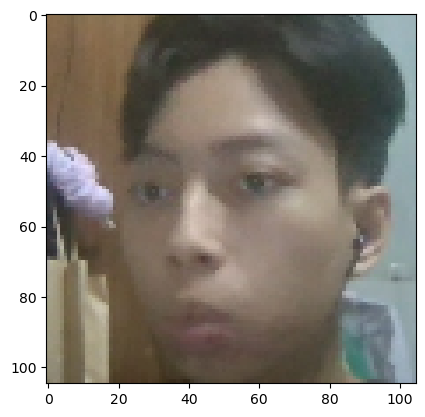

In [9]:
plt.imshow(img)

In [10]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [11]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [12]:
try_img = data.as_numpy_iterator()
try_img = try_img.next()
try_img

(b'data\\anchor\\4446d085-7413-11ef-ab9f-e81f155e7428.jpg',
 b'data\\positive\\cbbed82b-7413-11ef-a658-e81f155e7428.jpg',
 1.0)

In [13]:
def double_check(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)


In [14]:
res = double_check(*try_img)
res

(<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
 array([[[0.53538525, 0.42558137, 0.28048334],
         [0.53426707, 0.41662   , 0.27600372],
         [0.5311858 , 0.4117647 , 0.2837535 ],
         ...,
         [0.62082165, 0.69533145, 0.7110177 ],
         [0.62082165, 0.69533145, 0.7110177 ],
         [0.6129785 , 0.6874883 , 0.7110177 ]],
 
        [[0.53183943, 0.42175537, 0.27749768],
         [0.5181873 , 0.4042017 , 0.27090833],
         [0.52875817, 0.40974388, 0.28191277],
         ...,
         [0.61904764, 0.7022409 , 0.7137255 ],
         [0.61904764, 0.7022409 , 0.7137255 ],
         [0.6151261 , 0.6983193 , 0.70980394]],
 
        [[0.5232715 , 0.41486818, 0.2833089 ],
         [0.51966786, 0.4111378 , 0.28026545],
         [0.5197945 , 0.40961716, 0.28767505],
         ...,
         [0.6060691 , 0.7037348 , 0.70980394],
         [0.6077164 , 0.7020875 , 0.70980394],
         [0.6       , 0.69411767, 0.7019608 ]],
 
        ...,
 
        [[0.53229505, 0.50839216

In [15]:
#build pipline
data = data.map(double_check)
data = data.cache()
data = data.shuffle(buffer_size=2000)

In [16]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [17]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [18]:
test_data = data.skip(round(len(data)*.7))
test_data = data.take(round(len(data)*.3))
test_data = data.batch(16)
test_data = data.prefetch(8)

## Model

In [61]:
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [62]:
embed = make_embedding()
embed.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Siamese L1 Distance class
class L1Dist(tf.keras.layers.Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        if isinstance(input_embedding, list):
            input_embedding = tf.convert_to_tensor(input_embedding)
        if isinstance(validation_embedding, list):
            validation_embedding = tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_embedding - validation_embedding)

In [64]:
input_image = Input(name='input_img', shape=(105,105,3))
validation_image = Input(name='validation_img', shape=(105,105,3))

inp_embed = embed(input_image)
val_embed = embed(validation_image)


siamese_layer = L1Dist()


In [65]:
siamese_layer

<L1Dist name=l1_dist_3, built=False>

In [66]:
distances = siamese_layer(embed(input_image), embed(validation_image))
classifier = Dense(1,activation='sigmoid')(distances)

In [67]:
classifier

<KerasTensor shape=(1, None, 1), dtype=float32, sparse=False, name=keras_tensor_34>

In [78]:
def make_siames_model():
    input_image = Input(name='input_img', shape=(105,105,3))
    validation_image = Input(name='validation_img', shape=(100,100,3))

    siamese_layer = L1Dist()
    siamese_layer.name = 'distance'
    distances = siamese_layer(embed(input_image), embed(validation_image))

    classifier = Dense(1, activation ='sigmoid')(distances)

    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'Siamese_Network')


In [69]:
siamese_model = make_siames_model()

siamese_model.summary()

Model: "Siamese Network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance (L1Dist)   │ (1, None, 4096)   │          0 │ embedding[4][0],  │
│                     │                   │            │ embedding[5][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (1, None, 1)      │      4,097 │ distance[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Trainning


### Set up loss and optimize

In [70]:
binary_cross_loss = tf._losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [71]:
checkpoint_dir = './trainning_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model =siamese_model)


In [72]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1.],
      dtype=float32)

In [73]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as type:
        X = batch[:2]
        y = batch[2]

        y_pred = siamese_model(X, training = True)

        loss = binary_cross_loss(y, y_pred)
        print(loss)

    grad = tf.GradientTape(loss , siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss
        

In [74]:
from tensorflow.keras.metrics import Precision, Recall

In [75]:
def train(data, EPOCH):
    for epoch in range (1, EPOCH + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCH))
        progbar = tf.keras.utils.Progbar(len(data))

        r = Recall()
        p = Precision()

        for idx, batch in enumerate(data):
            loss = train_step(batch)
            y_pred = siamese_model.predict(batch[:2])
            r.update_state(batch[2], y_pred)
            p.update_state(batch[2], y_pred)
            progbar.update(idx+1)
    print(loss.numpy(), r.result().numpy(), p.result().numpy())

    if epoch % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

In [76]:
EPOCH = 50

In [79]:
train(train_data, EPOCH)


 Epoch 1/50


ValueError: in user code:

    File "C:\TEMP\ipykernel_12352\3397991926.py", line 10, in train_step  *
        loss = binary_cross_loss(y, y_pred)
    File "d:\Anaconda\Lib\site-packages\keras\src\losses\loss.py", line 60, in __call__  **
        losses = self.call(y_true, y_pred)
    File "d:\Anaconda\Lib\site-packages\keras\src\losses\losses.py", line 27, in call
        return self.fn(y_true, y_pred, **self._fn_kwargs)
    File "d:\Anaconda\Lib\site-packages\keras\src\losses\losses.py", line 1930, in binary_crossentropy
        ops.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "d:\Anaconda\Lib\site-packages\keras\src\ops\nn.py", line 1390, in binary_crossentropy
        return backend.nn.binary_crossentropy(
    File "d:\Anaconda\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 694, in binary_crossentropy
        raise ValueError(

    ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(16,), output.shape=(1, 16, 1)


In [ ]:
# call model, thử predict -> dimension, test function squeeze, unsqueeze xem biến đổi output nnao